
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


Please be sure that all modules listed below are installed on your machine.

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats import weightstats as stests
#Violinplot à tester

### Global parameter to build seaborn boxplot

In [2]:
# If necessary, update the path where all data are located.
# All computed p-values are gathered in a CSV file saved in the folder 'path'
# whose file name depends on the experiment results you want to see
path = 'data/Thesis/'
offset_path = len(path)

beacs = 'beacs-GA-ZIP-SLIP.json'
bacs = 'bacs-GA-ZIP-SLIP.json'
pepacs = 'pepacs-GA-ZIP-SLIP.json'

exp_list = [
    beacs,
    bacs,
    pepacs
]

exp_list_names = [
    'BEACS',
    'BACS',
    'PEPACS'
]

# Font size et figuresize parameters for plotting
figure_size = (20, 10)
axe_label_fontsize = '28'
tick_label_fontsize = '24'
legend_fontsize = '24'

# Significance level for p-values
alpha = 0.05
stat_file_name = 'stats'
produce_stat = False

### Please, do not modify any lines of code below

### Reading json files

In [3]:
def read_json(path, exp_list):
    raw_data = []
    for name in exp_list:
        json_data_from_lcs = path + name
        with open(json_data_from_lcs) as json_file:
            raw_data_from_lcs = json.load(json_file)
            raw_data.append(raw_data_from_lcs)
    return raw_data

# Call function to prepare plotting data
raw_data = read_json(path, exp_list)

### Preparing pandas plotting data

In [4]:
def prepare_pandas_plotting_data(raw_data, exp_list, exp_list_names):
    cleaned_data = {
        'LCS':[],
        'Maze':[],
        'Knowledge (%)':[],
        'Population of classifiers':[],
        'Reliable classifiers ratio':[],
        'Numerosity of classifiers':[], 
        'Compression rate':[],
        'Mean realiable classifier specificity':[], 
        'Full Knowledge for first time (trial)':[],
        #'Full Knowledge stable (trial)':[],
        #'Full Knowledge for last time (trial)':[],
        'Average EP Accumulated Error (%)':[],
        'Average steps to exit':[]
    }
    nb_of_environments = 0
    for i in range(len(exp_list_names)):
        for item in raw_data[i]:
            if 'time' not in item.keys():
                nb_of_environments += 1
                for idx in range(30):
                    cleaned_data['LCS'].append(exp_list_names[i])
                    if item['maze'][:-3] == "Woods101demi":
                        cleaned_data['Maze'].append("Woods101.5")
                    else:
                        cleaned_data['Maze'].append(item['maze'][:-3])
                    cleaned_data['Knowledge (%)'].append(
                        item['new_knowledge_list'][idx]
                    )
                    cleaned_data['Population of classifiers'].append(
                        item['new_population_list'][idx]
                    )
                    cleaned_data['Reliable classifiers ratio'].append(
                        float(item['new_reliable_list'][idx]) / item['new_population_list'][idx]
                    )
                    cleaned_data['Numerosity of classifiers'].append(
                        item['new_numerosity_list'][idx]
                    )
                    cleaned_data['Compression rate'].append(
                        1. - item['new_population_list'][idx] / item['old_population_list'][idx]
                    )
                    cleaned_data['Mean realiable classifier specificity'].append(
                        item['new_mean_reliable_classifier_specificity_list'][idx]
                    )
                    if item['full_knowledge_first_trial_list'][idx] < 0:
                        cleaned_data['Full Knowledge for first time (trial)'].append(
                            6000
                        )
                    else:
                        cleaned_data['Full Knowledge for first time (trial)'].append(
                            item['full_knowledge_first_trial_list'][idx]
                        )
                    #cleaned_data['Full Knowledge stable (trial)'].append(
                    #    item['full_knowledge_stable_trial_list'][idx]
                    #)
                    #cleaned_data['Full Knowledge for last time (trial)'].append(
                    #    item['full_knowledge_last_trial_list'][idx]
                    #)
                    cleaned_data['Average EP Accumulated Error (%)'].append(
                        item['new_pep_error_list'][idx]
                    )
                    cleaned_data['Average steps to exit'].append(
                        item['avg_exploit_rl_list'][idx]
                    )

    nb_of_environments /= len(exp_list)
    pandas_data = pd.DataFrame(cleaned_data)
    return nb_of_environments, pandas_data

nb_of_environments, pandas_data = prepare_pandas_plotting_data(raw_data, exp_list, exp_list_names)

### Plotting boxplots with seaborn

In [5]:
rc={
    'axes.labelsize':axe_label_fontsize,
    'xtick.labelsize':tick_label_fontsize,
    'ytick.labelsize':tick_label_fontsize
}
sns.set(context='notebook', style='ticks', rc=rc)

In [6]:
def plot_figure(pandas_data, Y, legend_loc, lcs_name):
    
    #palette = sns.color_palette('pastel')
    #color1=palette[0]
    #color2=palette[2]
    #pal = [color1, color2]
    
    # Build the main figure
    fig, ax = plt.subplots(figsize=figure_size)
    sns.stripplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        edgecolor='gray',
        jitter=True,
        linewidth = 1,
        dodge=True,
        #palette=pal,
        palette='pastel',
        ax = ax
    )#violinplot
    sns.boxplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        fliersize=0,
        #palette=pal,
        palette='pastel',
        ax = ax
    )

    # Set up x tick labels and x label correctly
    xlocs, xlabels = plt.xticks() 
    plt.xticks(np.arange(nb_of_environments)+0.5, xlabels, rotation = 45, horizontalalignment = 'right')
    plt.xlabel('')

    # Hide the horizontal gridlines
    ax.yaxis.grid(False)

    # Show the vertical gridlines
    ax.xaxis.grid(True)

    # Set up minor ticks and align label of major ticks on minor ticks
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    dx = (((figure_size[0] * 100 / 4.))/nb_of_environments - 10)/72.; dy = 0/72. # Width in inches converted into pixels depending on default DPI
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() - offset)

    # Set up legend
    handles, _ = ax.get_legend_handles_labels()
    plt.legend(handles[0:len(lcs_name)], lcs_name[0:len(lcs_name)], frameon=False, fontsize=legend_fontsize)#, loc=legend_loc)


In [7]:
def plot_knowledge(pandas_data, zipped:bool=True):
    plot_figure(pandas_data, Y='Knowledge (%)', legend_loc='lower right', lcs_name=exp_list_names)
    
def plot_whole_population(pandas_data):
    plot_figure(pandas_data, Y='Population of classifiers', legend_loc='upper right', lcs_name=exp_list_names)
    
def plot_reliable_population(pandas_data):
    plot_figure(pandas_data, Y='Reliable classifiers ratio', legend_loc='upper right', lcs_name=exp_list_names)

def plot_numerosity(pandas_data):
    plot_figure(pandas_data, Y='Numerosity of classifiers', legend_loc='lower right', lcs_name=exp_list_names)

def plot_mean_classifier_specificity(pandas_data):
    plot_figure(pandas_data, Y='Mean realiable classifier specificity', legend_loc='lower left', lcs_name=exp_list_names)

def plot_compression_rate(pandas_data):
    plot_figure(pandas_data, Y='Compression rate', legend_loc='lower left', lcs_name=exp_list_names)

def plot_first_time_full_knowledge_achieved(pandas_data):
    plot_figure(pandas_data, Y='Full Knowledge for first time (trial)', legend_loc='upper right', lcs_name=exp_list_names)

def plot_last_time_full_knowledge_achieved(pandas_data):
    plot_figure(pandas_data, Y='Full Knowledge for last time (trial)', legend_loc='lower right', lcs_name=exp_list_names)

def plot_ep_accumulated_error(pandas_data):
    plot_figure(pandas_data, Y='Average EP Accumulated Error (%)', legend_loc='upper right', lcs_name=exp_list_names)

def plot_avg_steps_to_exit(pandas_data):
    plot_figure(pandas_data, Y='Average steps to exit', legend_loc='upper right', lcs_name=exp_list_names)


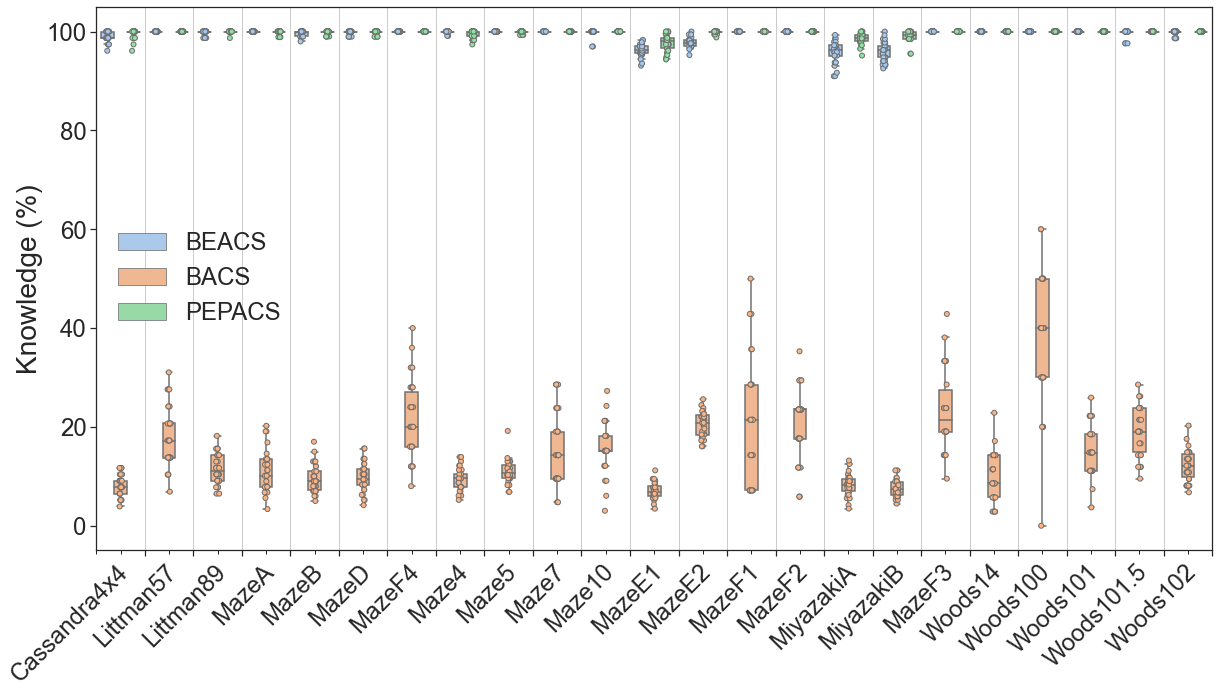

In [8]:
plot_knowledge(pandas_data)

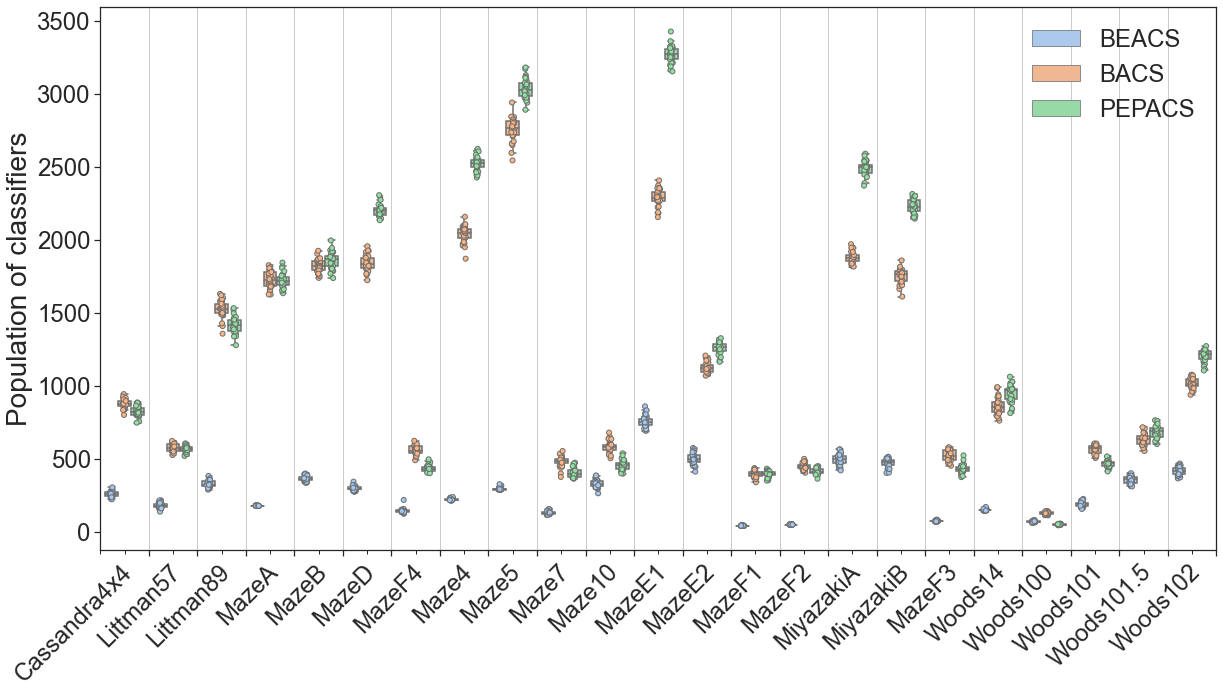

In [9]:
plot_whole_population(pandas_data)

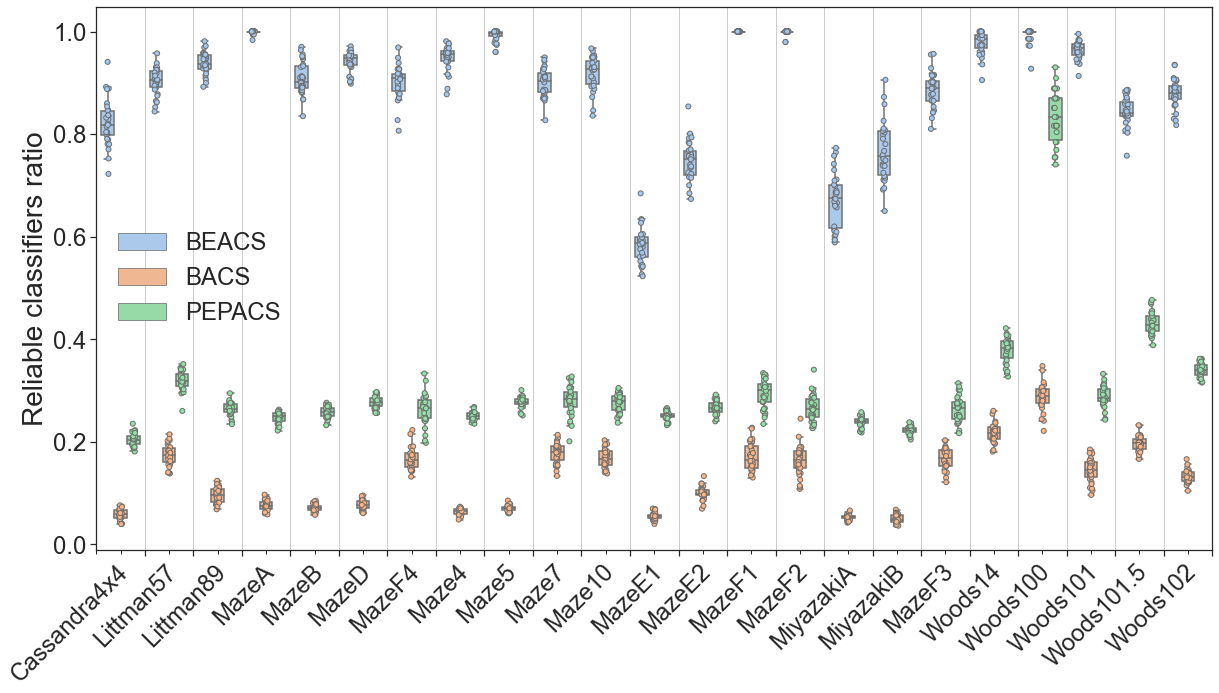

In [10]:
plot_reliable_population(pandas_data)

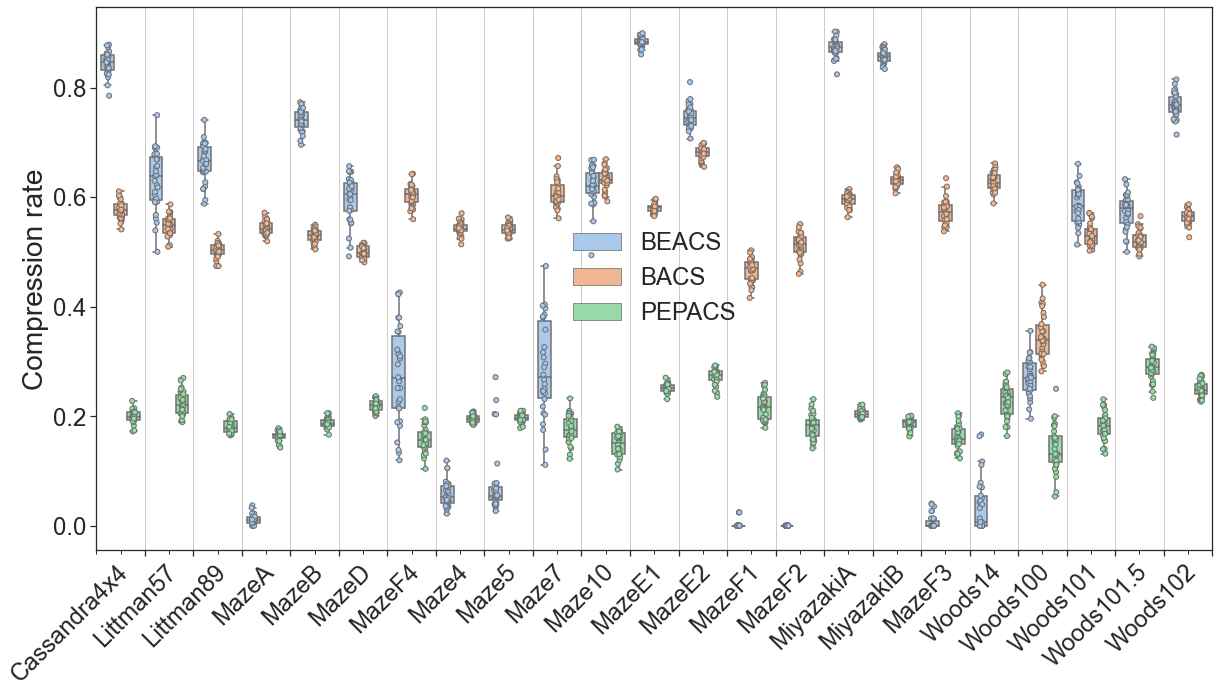

In [11]:
plot_compression_rate(pandas_data)

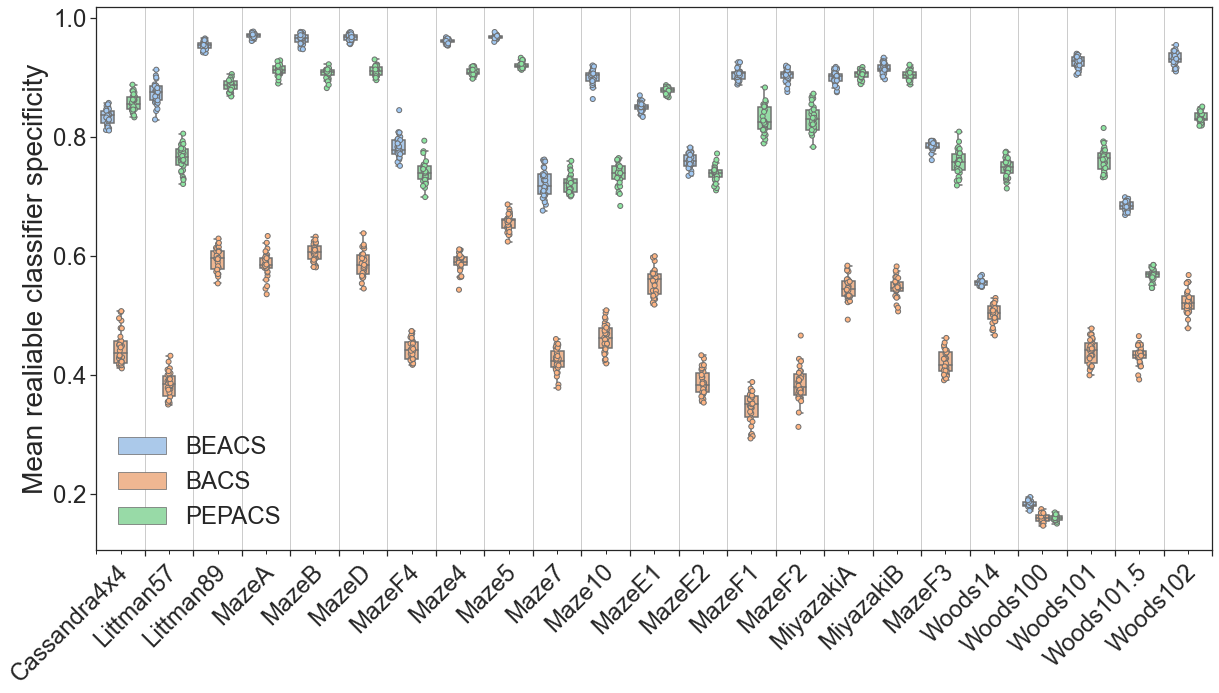

In [12]:
plot_mean_classifier_specificity(pandas_data)

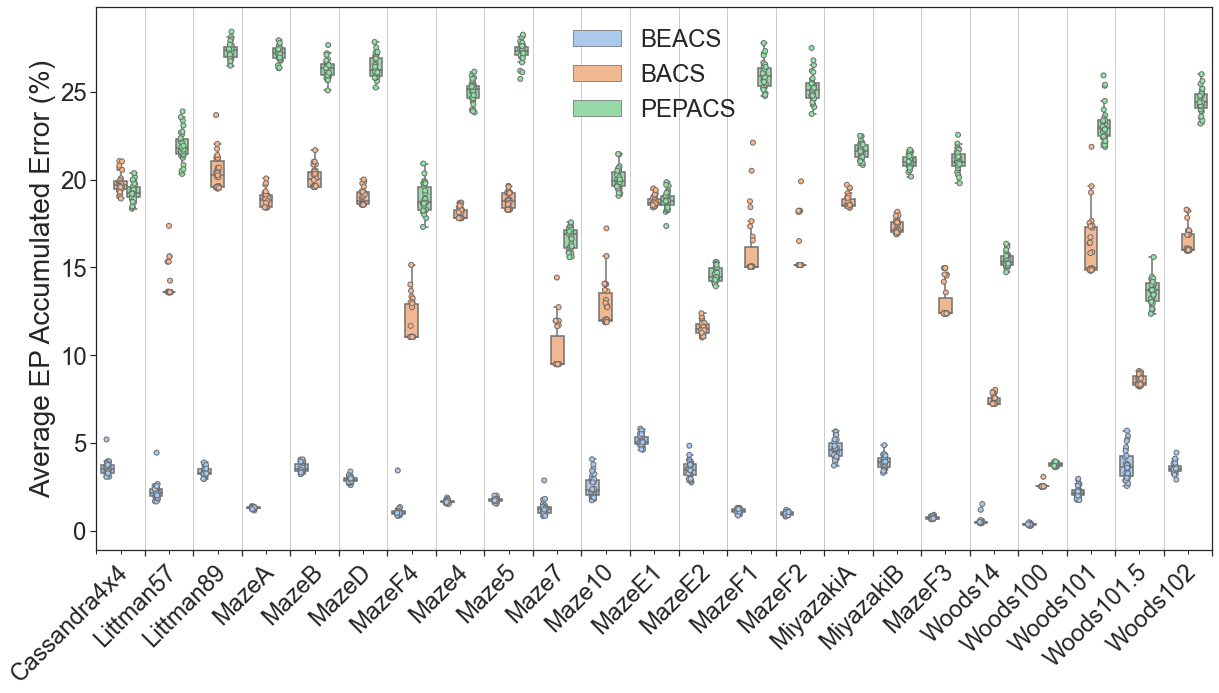

In [13]:
plot_ep_accumulated_error(pandas_data)

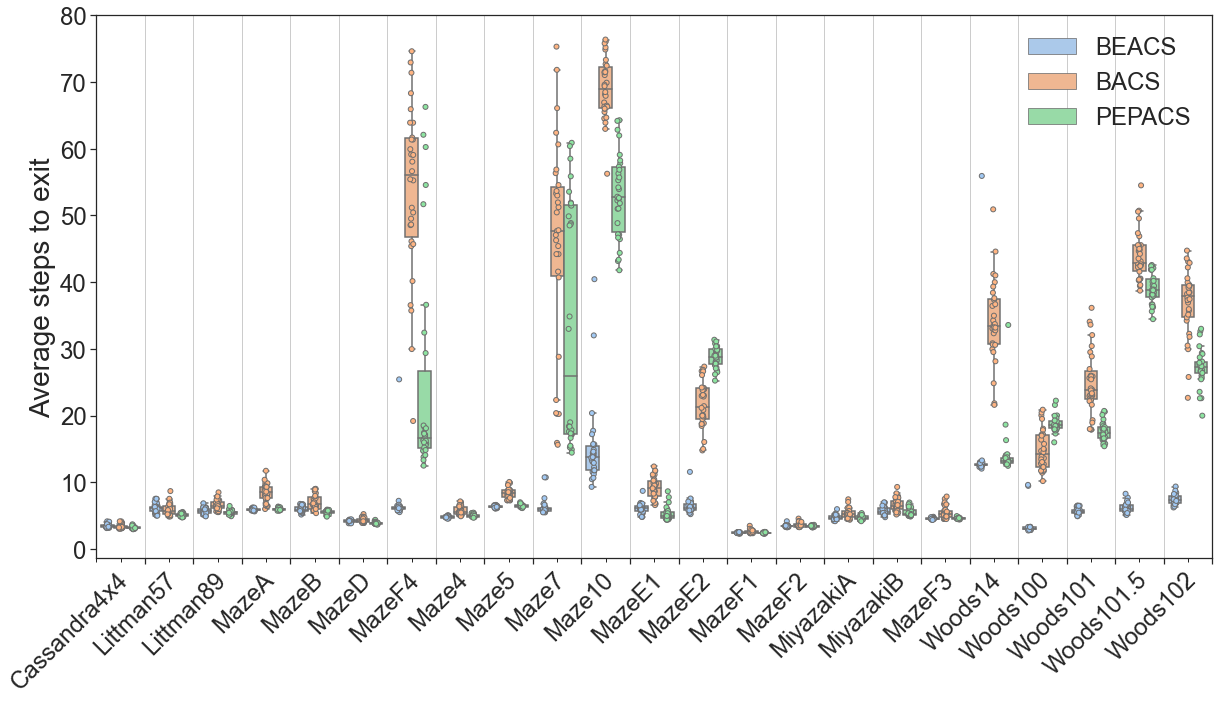

In [14]:
plot_avg_steps_to_exit(pandas_data)

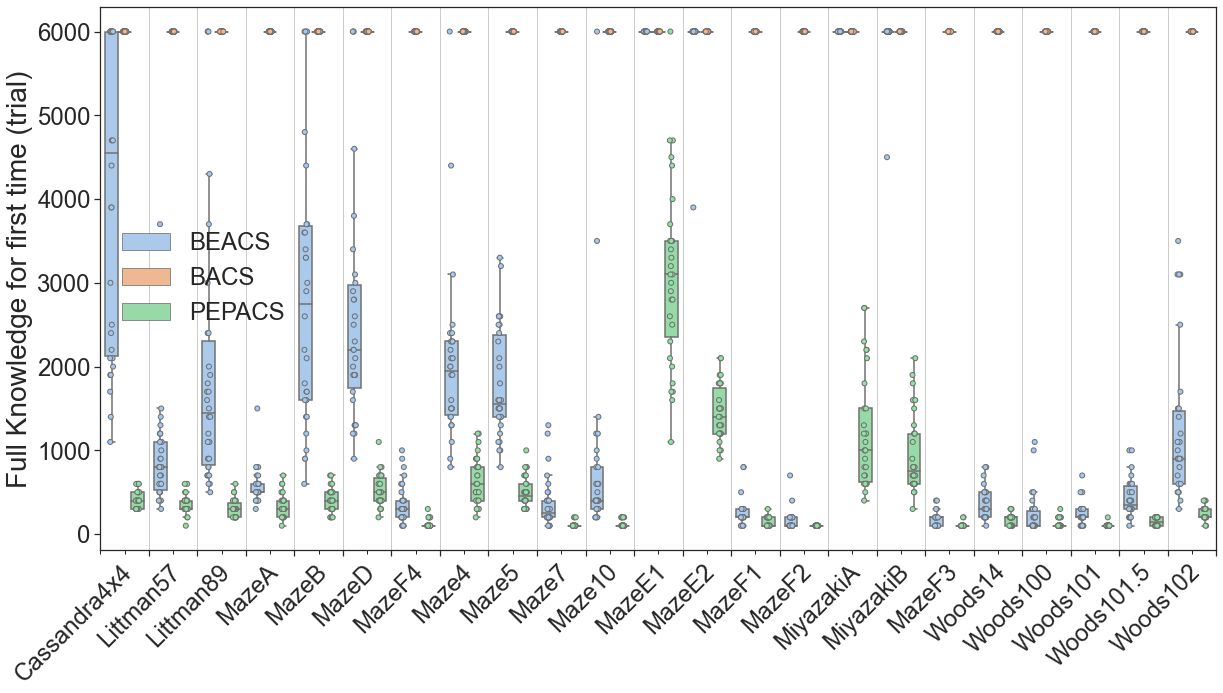

In [15]:
plot_first_time_full_knowledge_achieved(pandas_data)
#plot_last_time_full_knowledge_achieved(pandas_data)

### Preparing statistical data from raw read json

In [16]:
if produce_stat:
    raw_list_by_env_name = {}
    for i in range(len(exp_list_names)):
        for item in raw_data[i]:
            if 'time' not in item.keys():
                if item['maze'] not in raw_list_by_env_name.keys():
                    raw_list_by_env_name[item['maze']] = {
                    #    'knowledge_list' : [],
                    #    'population_list' : [],
                    #    'reliable_list' : [],
                    #    'mean_reliable_classifier_specificity_list' : [],
                    #    'full_knowledge_first_trial_list' : [],
                    #    'full_knowledge_last_trial_list' : [],
                        'PEP_Accumulated_Error' : [],
                    #    'Average_steps_to_exit' : []
                    }
                #raw_list_by_env_name[item['maze']]['knowledge_list'].append(
                #    np.array(item['knowledge_list']))
                #raw_list_by_env_name[item['maze']]['population_list'].append(
                #    np.array(item['population_list']))
                #raw_list_by_env_name[item['maze']]['reliable_list'].append(
                #    np.array(item['reliable_list']))
                #raw_list_by_env_name[item['maze']]['mean_reliable_classifier_specificity_list'].append(
                #    np.array(item['mean_reliable_classifier_specificity_list']))
                #raw_list_by_env_name[item['maze']]['full_knowledge_first_trial_list'].append(
                #    np.array(item['full_knowledge_first_trial_list']))
                #raw_list_by_env_name[item['maze']]['full_knowledge_last_trial_list'].append(
                #    np.array(item['full_knowledge_last_trial_list']))
                raw_list_by_env_name[item['maze']]['PEP_Accumulated_Error'].append(
                    np.array(item['old_pep_error_list']))
                #raw_list_by_env_name[item['maze']]['Average_steps_to_exit'].append(
                #    np.array(item['avg_exploit_rl_list']))

### Computing p-values

In [17]:
if produce_stat:
    raw_statistical_data = {
        'Maze':[],
        'Metric':[],
        'ALCS':[],
        'Alternative':[],
        'Degrees of freedom':[],
        'P Value':[],
        'Null Hypothesis':[]
    }
    for env_name in raw_list_by_env_name.keys():
        for metric in raw_list_by_env_name[env_name].keys():
            for i in range(3):
                raw_statistical_data['Maze'].append(env_name)
                raw_statistical_data['Metric'].append(metric)
                raw_statistical_data['ALCS'].append('BEACS-BACS')
                x1 = np.array(raw_list_by_env_name[env_name][metric][0])
                x2 = np.array(raw_list_by_env_name[env_name][metric][1])
                if i == 0:
                    alt = 'two-sided'
                elif i == 1:
                    alt = 'larger'
                else:
                    alt = 'smaller'
                raw_statistical_data['Alternative'].append(alt)
                tstats, pvalue, dof = stests.ttest_ind(x1, x2, alternative=alt, usevar='unequal', value=0)
                raw_statistical_data['Degrees of freedom'].append(dof)
                raw_statistical_data['P Value'].append(pvalue)
                if pvalue<alpha:
                    raw_statistical_data['Null Hypothesis'].append('Reject')
                else:
                    raw_statistical_data['Null Hypothesis'].append('Accept')
                if len(exp_list) == 3 :
                    raw_statistical_data['Maze'].append(env_name)
                    raw_statistical_data['Metric'].append(metric)
                    raw_statistical_data['ALCS'].append('BEACS-PEPACS')
                    x1 = np.array(raw_list_by_env_name[env_name][metric][0])
                    x2 = np.array(raw_list_by_env_name[env_name][metric][2])
                    if i == 0:
                        alt = 'two-sided'
                    elif i == 1:
                        alt = 'larger'
                    else:
                        alt = 'smaller'
                    raw_statistical_data['Alternative'].append(alt)
                    tstats, pvalue, dof = stests.ttest_ind(x1, x2, alternative=alt, usevar='unequal', value=0)
                    raw_statistical_data['Degrees of freedom'].append(dof)
                    raw_statistical_data['P Value'].append(pvalue)
                    if pvalue<alpha:
                        raw_statistical_data['Null Hypothesis'].append('Reject')
                    else:
                        raw_statistical_data['Null Hypothesis'].append('Accept')

                    raw_statistical_data['Maze'].append(env_name)
                    raw_statistical_data['Metric'].append(metric)
                    raw_statistical_data['ALCS'].append('BACS-PEPACS')
                    x1 = np.array(raw_list_by_env_name[env_name][metric][1])
                    x2 = np.array(raw_list_by_env_name[env_name][metric][2])
                    if i == 0:
                        alt = 'two-sided'
                    elif i == 1:
                        alt = 'larger'
                    else:
                        alt = 'smaller'
                    raw_statistical_data['Alternative'].append(alt)
                    tstats, pvalue, dof = stests.ttest_ind(x1, x2, alternative=alt, usevar='unequal', value=0)
                    raw_statistical_data['Degrees of freedom'].append(dof)
                    raw_statistical_data['P Value'].append(pvalue)
                    if pvalue<alpha:
                        raw_statistical_data['Null Hypothesis'].append('Reject')
                    else:
                        raw_statistical_data['Null Hypothesis'].append('Accept')
    statistical_pandas = pd.DataFrame(raw_statistical_data)

In [18]:
if produce_stat:
    statistical_pandas.to_csv(path + stat_file_name + '.csv')